In [221]:
import jax.numpy as jnp
from jax import random, grad, vmap, jit

from scipy.special import legendre

import matplotlib.pyplot as plt

In [222]:
# # Activation functions
def softplus(x):
    return jnp.log(1. + jnp.exp(x))

def sigmoid(x):
    return 1./(1. + jnp.exp(-x))

# # jnp.exp OVERFLOWS!!!

# # Blocks
def legendre_block(m, n, params_l, x):
  w_l, b_l = params_l
  h_l = jnp.tanh(x*w_l + b_l)
  return jnp.array([legendre(n_i)(h_l) for n_i in range(n)])

def chebyshev_block(x):
  raise NotImplementedError

In [223]:
# # Neural network
def f(params, x):
    w0 = params[:80]
    b0 = params[80:160]
    w1 = params[160:240]
    b1 = params[240]
    h = softplus(x*w0 + b0)
    return jnp.sum(h*w1) + b1

def g(m, n, params, x):
  raise NotImplementedError

dfdx = grad(f, 1)
dfdx2 = grad(dfdx, 1)
f_vect = vmap(f, (None, 0))
dfdx_vect = vmap(dfdx, (None, 0))
dfdx2_vect = vmap(dfdx2, (None, 0))

In [224]:
# # Loss function
# # standart Lane-Emden eqn. with m = 0
@jit
def loss(params, x):
    eqn = dfdx2_vect(params, x) + (2/x)*dfdx_vect(params, x) + 1
    bc1 = f(params, 0.) - 1
    bc2 = dfdx(params, 0.)
    return jnp.mean(eqn**2) + bc1**2 + bc2**2

grad_loss = jit(grad(loss, 0))

In [228]:
inputs = jnp.linspace(1, 4, num=801)

In [229]:
# # Initiating parameters
key = random.PRNGKey(0)
params = random.normal(key, shape=(241,))

In [230]:
# # Training
epochs = 1000
learning_rate = 0.0005
momentum = 0.99
velocity = 0.

for epoch in range(epochs):
    if epoch % 100  == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss(params, inputs)))
    gradient = grad_loss(params + momentum*velocity, inputs)
    velocity = momentum*velocity - learning_rate*gradient
    params += velocity

epoch:   0 loss: 74.784676
epoch: 100 loss: 0.119401
epoch: 200 loss: 0.007107
epoch: 300 loss: 0.035827
epoch: 400 loss: 0.006120
epoch: 500 loss: 0.005671
epoch: 600 loss: 0.002065
epoch: 700 loss: 0.002193
epoch: 800 loss: 0.001759
epoch: 900 loss: 0.001598


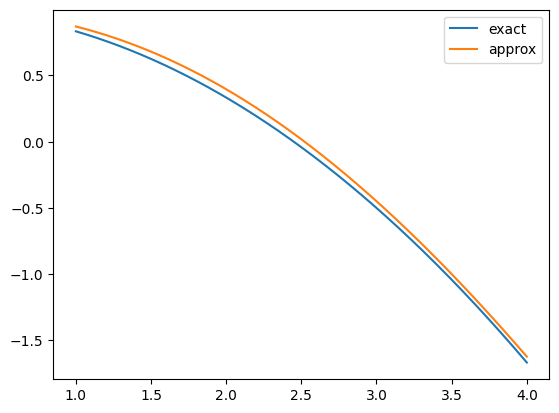

In [231]:
plt.plot(inputs, 1. - (inputs**2)/6, label='exact')
plt.plot(inputs, f_vect(params, inputs), label='approx')
plt.legend()
plt.show()